In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc,roc_curve
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

nrows = 50000

In [2]:
def kf_with_model(data,model = LogisticRegression(C=0.01,class_weight='balanced')):
    kf = KFold(5)
    res = pd.DataFrame()

    for train_index,test_index in kf.split(data):
        model_train = data.iloc[train_index]
        model_test = data.iloc[test_index]

        train_y = model_train['target']
        train_x = model_train.drop('target',axis = 1)

        test_y = model_test['target']
        test_x = model_test.drop('target', axis = 1)

        model.fit(train_x,train_y)

        pred_label = model.predict(test_x)
        pred_prob = model.predict_proba(test_x)

        preds = pd.DataFrame()
        preds['label'] = test_y
        preds['pred'] = pred_label
        preds['prob'] = pred_prob[:,1]
        res = res.append(preds)
    return(res)

def plotGraph(df):
    predicts_list = df.columns[1:]
    aucs = pd.DataFrame(columns=['models','auc_score'])
    y = df['label']
    for res in predicts_list:
        fpr,tpr,thres = roc_curve(y,df[res])
        auc_score = auc(fpr,tpr)
        aucs = aucs.append({'models':res,'auc_score':auc_score},ignore_index=True)
        
        plt.plot(fpr,tpr,lw=1, alpha=0.3,label = res+' : '+str(round(auc_score,3)))
    
    plt.legend(loc='lower right')
    plt.show()
    return(aucs)

In [3]:
raw_train = pd.read_csv('../data/train.csv',nrows=nrows)

In [4]:
raw_train.drop('ID_code',inplace=True,axis=1)
raw_train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
y = raw_train['target']
x = raw_train.drop('target',axis=1)
features = raw_train.columns[1:]
del raw_train

In [6]:
min_max_scale = MinMaxScaler().fit_transform(x)
std_scale = StandardScaler().fit_transform(x)

In [7]:
min_max_train = pd.DataFrame(min_max_scale)
min_max_train.columns = features
min_max_train.insert(0,'target',y)


std_train = pd.DataFrame(std_scale)
std_train.columns = features
std_train.insert(0,'target',y)

p_values = f_classif(x,y)[1] < 0.05
selected_features = features[p_values]
selected_train = x[selected_features]
selected_train.insert(0,'target',y)

In [8]:
min_max_res = kf_with_model(min_max_train)
std_res = kf_with_model(std_train)
fs_res = kf_with_model(selected_train)

In [9]:
result_df = pd.DataFrame()
result_df['label'] = y

In [10]:
result_df['min_max'] = min_max_res['prob']
result_df['std'] = std_res['prob']
result_df['fs'] = fs_res['prob']

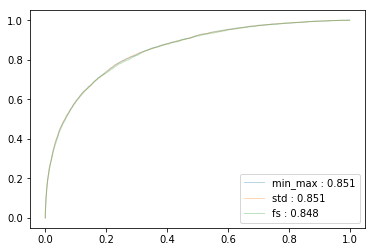

,models,auc_score
0,min_max,0.851127
1,std,0.850703
2,fs,0.848339


In [11]:
plotGraph(result_df)